In [1]:
import os
os.chdir('../')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import os
import sys
import numpy as np
import scipy.io as spio
import scipy as sp
from PIL import Image
from scipy.stats import pearsonr,binom,linregress
import numpy as np

In [2]:
def pairwise_corr_all(ground_truth, predictions):
    r = np.corrcoef(ground_truth, predictions)#cosine_similarity(ground_truth, predictions)#
    r = r[:len(ground_truth), len(ground_truth):]  # rows: groundtruth, columns: predicitons
    #print(r.shape)
    # congruent pairs are on diagonal
    congruents = np.diag(r)
    #print(congruents)
    
    # for each column (predicition) we should count the number of rows (groundtruth) that the value is lower than the congruent (e.g. success).
    success = r < congruents
    success_cnt = np.sum(success, 0)
    
    # note: diagonal of 'success' is always zero so we can discard it. That's why we divide by len-1
    perf = np.mean(success_cnt) / (len(ground_truth)-1)
    p = 1 - binom.cdf(perf*len(ground_truth)*(len(ground_truth)-1), len(ground_truth)*(len(ground_truth)-1), 0.5)
    
    return perf, p

def pairwise_corr_individuals(ground_truth, predictions):
    r = np.corrcoef(ground_truth, predictions)#cosine_similarity(ground_truth, predictions)#
    r = r[:len(ground_truth), len(ground_truth):]  # rows: groundtruth, columns: predicitons
    #print(r.shape)
    # congruent pairs are on diagonal
    congruents = np.diag(r)
    #print(congruents)
    
    # for each column (predicition) we should count the number of rows (groundtruth) that the value is lower than the congruent (e.g. success).
    success = r < congruents
    success_cnt = np.sum(success, 0)
    
    # note: diagonal of 'success' is always zero so we can discard it. That's why we divide by len-1
    perf = success_cnt / (len(ground_truth)-1)
    # p = 1 - binom.cdf(perf*len(ground_truth)*(len(ground_truth)-1), len(ground_truth)*(len(ground_truth)-1), 0.5)
    
    return perf


net_list = [
    ('inceptionv3','avgpool'),
    ('clip','final'),
    ('alexnet',2),
    ('alexnet',5),
    ('efficientnet','avgpool'),
    ('swav','avgpool')
    ]

In [3]:
num_test = 200
test_dir = 'cache/thingseeg2_preproc/eval_features/test_images'
feats_dir = 'cache/thingseeg2_preproc/eval_features/subj1_preproc_800ms'
distance_fn = sp.spatial.distance.correlation
pairwise_corrs = []
for (net_name,layer) in net_list:
    file_name = '{}/{}_{}.npy'.format(test_dir,net_name,layer)
    gt_feat = np.load(file_name)
    
    file_name = '{}/{}_{}.npy'.format(feats_dir,net_name,layer)
    eval_feat = np.load(file_name)
    
    gt_feat = gt_feat.reshape((len(gt_feat),-1))
    eval_feat = eval_feat.reshape((len(eval_feat),-1))

    print(net_name,layer)
    if net_name in ['efficientnet','swav']:
        print('distance: ',np.array([distance_fn(gt_feat[i],eval_feat[i]) for i in range(num_test)]).mean())
    else:
        # pairwise_corrs.append(pairwise_corr_all(gt_feat[:num_test],eval_feat[:num_test])[0])
        pairwise_corrs.append(pairwise_corr_individuals(gt_feat[:num_test],eval_feat[:num_test]))
        # print('pairwise corr: ',pairwise_corrs[-1])

inceptionv3 avgpool
clip final
alexnet 2
alexnet 5
efficientnet avgpool
distance:  0.9121800053943298
swav avgpool
distance:  0.5758596473932266


In [4]:
inception_inds = np.argsort(pairwise_corrs[0])[::-1]
clip_inds = np.argsort(pairwise_corrs[1])[::-1]
alexnet2_inds = np.argsort(pairwise_corrs[2])[::-1]
alexnet5_inds = np.argsort(pairwise_corrs[3])[::-1]

In [5]:
# pairwise_corr_individuals(gt_feat[:num_test],eval_feat[:num_test])

In [10]:
# image_ids = [87, 104, 183, 184,  86, 188, 126, 101, 100,  93]
image_ids = clip_inds
def load_test_image(image_id):
    return mpimg.imread(f'data/things-eeg2_preproc/test_images_direct/{image_id}.png')
def load_recon_image(image_id):
    return mpimg.imread(f'results/thingseeg2_preproc/versatile_diffusion_800ms/{image_id}.png')
# Load stimulus images
stimulus_images = [load_test_image(image_id) for image_id in image_ids]
# Load reconstructed images
# This will depend on how your reconstructed images are stored
# For this example, let's assume they're in the same directory with a '_reconstructed' suffix
reconstructed_images = [load_recon_image(image_id) for image_id in image_ids]

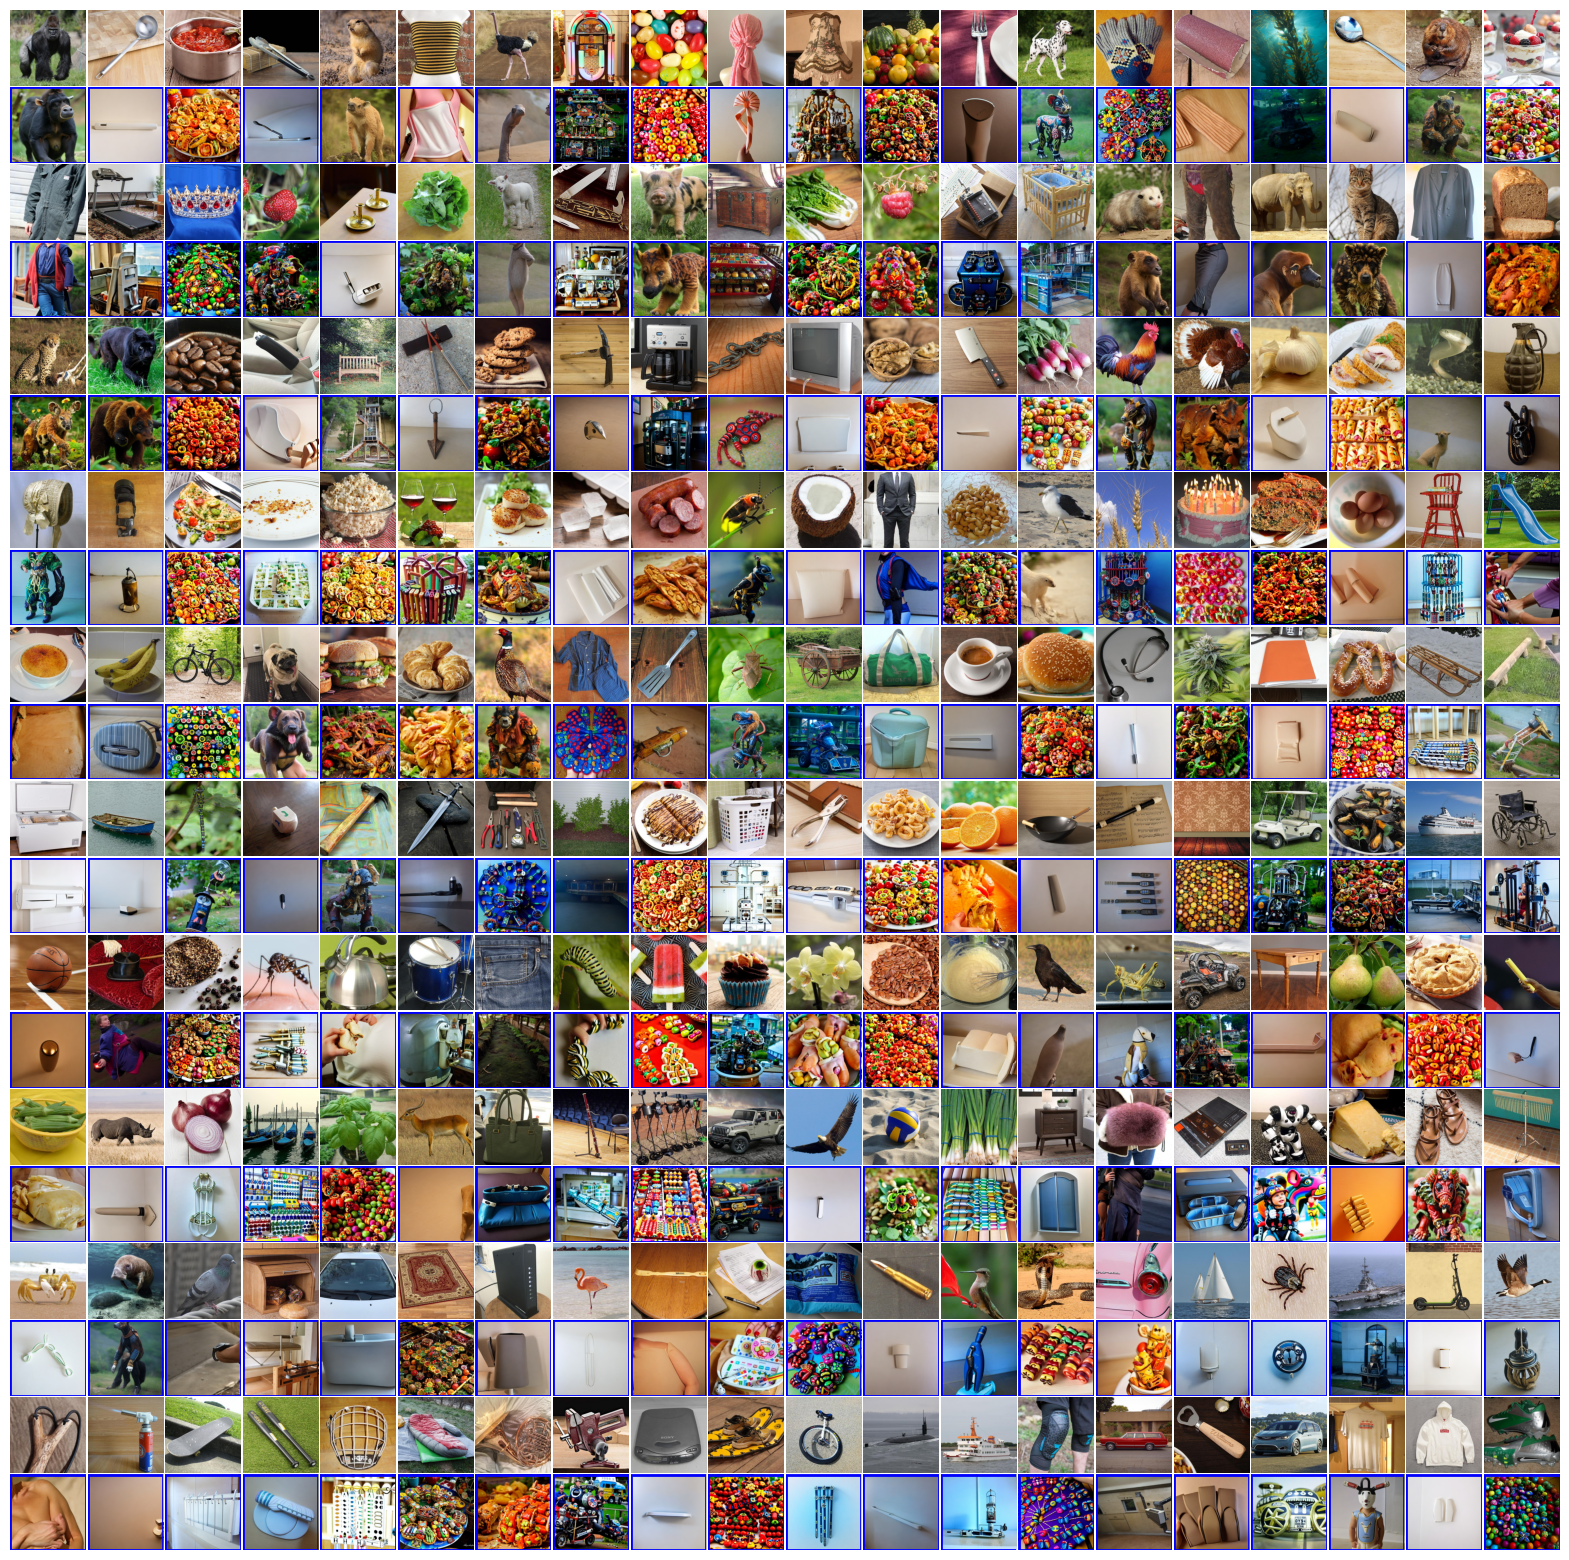

In [11]:
# Create figure
fig, axs = plt.subplots(20, 20, figsize=(20, 20))

for row in range(10):
    # Add stimulus images to top row
    for i, img in enumerate(stimulus_images[20 * row:20 * row + 20]):
        axs[2 * row, i].imshow(img)
        axs[2 * row, i].axis('off')

    # Add reconstructed images to bottom row with a red frame
    for i, img in enumerate(reconstructed_images[20 * row:20 * row + 20]):
        axs[2 * row + 1, i].imshow(img)
        axs[2 * row + 1, i].axis('off')
        # Add a red frame
        rect = Rectangle((0,0), img.shape[1], img.shape[0], linewidth=2, edgecolor='b', facecolor='none')
        axs[2 * row + 1, i].add_patch(rect)

# Reduce the gap between images
plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

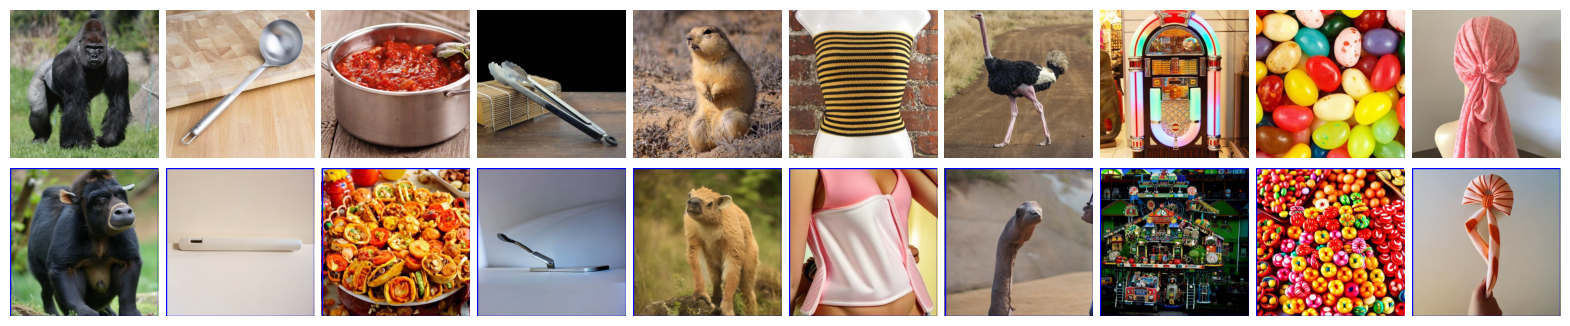

In [29]:
# # Create figure
# fig, axs = plt.subplots(2, len(image_ids), figsize=(20, 4))

# # Add stimulus images to top row
# for i, img in enumerate(stimulus_images):
#     axs[0, i].imshow(img)
#     axs[0, i].axis('off')

# # Add reconstructed images to bottom row with a red frame
# for i, img in enumerate(reconstructed_images):
#     axs[1, i].imshow(img)
#     axs[1, i].axis('off')
#     # Add a red frame
#     rect = Rectangle((0,0), img.shape[1], img.shape[0], linewidth=1, edgecolor='b', facecolor='none')
#     axs[1, i].add_patch(rect)

# # Reduce the gap between images
# plt.subplots_adjust(wspace=0.05, hspace=0.05)

# plt.show()